<a href="https://colab.research.google.com/github/warenya/demo-repo2/blob/master/GCANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Geometric Clifford Algebra Networks (GCANs) in Robotics**

### **An Introduction to the Research & Colab**
Conventional methods for modeling the dynamics of robots often depend on intricate kinematic and dynamic equations. Geometric Clifford Algebra Networks (GCANs) have the potential to provide a more intuitive and efficient approach due to their ability to capture geometric transformations and relationships. This research aims to outline the problem, focusing on the creation and assessment of GCAN models for predicting the motion and forces exerted by robotic arms across various scenarios. While we have some additional insights, the complexity and lack of research for this topic combined with the short timeframe was quite a challenge for us to tackle.


We will walk you through the sections in this notebook 


1.   **Sandbox :** Here, you will find all the packages we will use in this notebook. There are quite a few uncommon ones with Clifford Algebra like Cliffodlayers!
2.   **GCAN Code :** This section has our GCA-MLP which we've used for all of our implementations, and also some of applications we tried it on. We'll get into more details later 
3.  **Traditional MLP and CNN :** We used this to see how well our model fares with traditional MLP and CNN models for the same tasks.
4.  **Application in Robot Dynamics :** This is our application of the GCA-MLP in robotics. It's still at a very early stage but we are working on it. 🚧






## **Geometric Clifford Algebra Networks: A Swift Introduction**

Geometric Clifford Algebra Networks (GCANs) are a newly developed class of neural architectures that use geometric algebra to naturally integrate geometric-driven transformations into their learning process. They rely on group action layers, which apply combinations of predefined geometric transformations (such as rotations or reflections) directly to the input data. The advantage behind GCANs is that they respect and preserve the geometric structure and meaning of their inputs. For example, vectors remain vectors, and geometric entitites like lines or planes remain in their respective geometric "grades".
As a result, as described in the GCAN paper by Ruhe et al., GCANs serve as flexible "geometric templates," allowing networks to capture and reason about the underlying spatial symmetries and invariances present in complex data.

### **A Structural Walk-through**
Traditional neural networks would treat these inputs as raw numeric data and arbitrarily transform them. In contrast, GCANs employ geometric algebra to ensure that these transformations always respect the underlying geometric structure of the input.
The input data are represented as k-vectors within a Clifford algebra.
At the core of a GCAN are group action layers. These layers don't just multiply by arbitrary weight matrices. Instead, they use transformations from a well-defined group, often a group like Spin(p, q, r) which encodes rotations and reflections. Formally, for each layer, we have a handful of learned transformations $a_i$ belonging to the chosen group $G$. Acting on an input $x$, each $a_i$ sends $x$ to $a_ixa^{-1}_i$, also known as the "sandwich" product, which basically "sandwiches" $x$ between $a$ and its inverse. This operation encodes how the transformation by $a$ modifies $x$. For example, if $a$ represents a rotation in space, then performing the sandwich product applies that rotation to the object $x$.

And instead of applying just one transformation, a GCAN layer forms a linear combination of several group actions:
$T_{g, w}(x) = ∑_{i=1}^{c} w_i \cdot (a_i x a_i^{-1})$,
where $w_i$ are scalar weights learned by the network.

Because each transformation $a_i x a_i^{-1}$ is a proper group action, it doesn't just scramble the input's geometric structure. If $x$ started as a vector (1-vector), applying the sandwich product will produce another 1-vector. As such, geometric types are preserved.

To build a full neural network, GCANs also incorporate non-linearities and normalization steps which are also chosen to respect the geometric algebra's structure (i.e. MSiLU).

When we stack multiple group action layers, we are essentially chaining together sequences of structured geometric transformations. Through training, the network "learns" to harness these transformations to solve tasks, from modeling physical systems (like predicting the moiton of objects under rotations and translations) to complex fluid dynamics and PDE modeling.

---

#### **Sidenote: What is Multivector Sigmoid Linear Unit (MSiLU) activation?**
A multivector sigmoid linear unit is a specialized nonlinearity designed for use within geometric algebra frameworks. Unlike a standard sigmoid or ReLU, which simply apply a scalar nonlinear function element-wise to a real vector, the multivector sigmoid linear unit operates on multivectors and preserves their geometric structure (such as separating out scalar, vector, and higher-grade parts). Essentially, it applies nonlinear transformations in a way that ensures each geometric component (e.g., scalars remain scalars, vectors remain vectors) is consistently treated, maintaining the integrity of the underlying geometric representation.

The key difference is that the Multivector SiLU (MSiLU) applies its nonlinear transformation while respecting the grade decomposition of the input. In other words, it treats each geometric part (scalar, vector, bivector, etc.) separately, applying a suitable nonlinearity to each grade component. This ensures that each type of geometric element remains within its own “grade” and does not get mixed into other parts of the multivector, thus preserving the overall geometric structure.

---

# **Downloads & imports required**

In [ ]:
!pip install cliffordlayers
!pip install --upgrade clifford

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 13.9 MB/s eta 0:00:00


In [ ]:
!pip install numba==0.58.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 MB 11.8 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninstalled numba-0.60.0


In [ ]:
import clifford as cf
import scipy as e
from scipy import linalg
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from numpy import pi
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from clifford import Cl
from cliffordlayers.nn.modules.groupnorm import CliffordGroupNorm1d
from cliffordlayers.nn.modules.cliffordconv import _CliffordConvNd
from cliffordlayers.nn.modules.batchnorm import _CliffordBatchNorm
from cliffordlayers.nn.modules.cliffordlinear import CliffordLinear
from cliffordlayers import signature

%matplotlib inline

# **GCAN code**

Areas to refine:


*   Accuracy
*   Time for convergence

Notably and as expressed in the GCAN paper, the time for convergence is generally quite slow due to the complexity of operations being done. This slowness is especially prevalent when applying the GCAN to 2D data; we have seen that doing so is a bit "overkill" and unnecessarily complicates the procedure.

## **GCA-MLP**

This model blends deep learning with Clifford algebra to handle geometric data. It’s designed to process and classify shapes and transformations using multivector embeddings, which represent geometric objects in higher dimensions. Here’s a summary:

**Key Components:**

1. **Clifford Algebra:**

  a. **CliffordAlgebra Class:**  This class handles operations l ike geometric products and embedding multivector data.

  b. **PGAConjugateLinear Layer:** This class transforms multivectors using operations from Clifford algebra, enabling rotations and reflections.

2. **Neural Network Architecture:**

  a. **MultiVectorEmbedding:** Converts input data (like 2D points) into multivector components.

  b. **GCALayer:** Combines algebraic transformations with normalization and custom activations.

  c. **GCA_MLP:** A multi-layer perceptron that processes data through Clifford algebra layers, applying geometric transformations.

3. **Features:**

  a. **Multivector Representation:** Allows rich transformations (like rotations) for geometric data.

  b. **Custom Activation (MSiLU):** Preserves geometric properties during transformations.

  c. **Aggregation Methods:** Combines features in various ways to enhance processing.

4. **Applications:**
  
  a. **Geometric Learning:** We used this for shape recognition, but it can also be used for tasks like point cloud processing.
  
  b. **GeoClassifier:** Classifier based on learned geometric features, used for image and shape classification.



In [ ]:
# Define the geometric algebra parameters
layout, blades = Cl(2, 0)
num_blades = len(layout.blades_list)
g = [1, 1]  # Signature

blade_tuple_to_idx = {key: idx for idx, key in enumerate(layout.blades.keys())}
idx_to_blade_tuple = {idx: key for key, idx in blade_tuple_to_idx.items()}

def ensure_tensor(x, dtype=torch.float32, device=None):
    """Ensure input is a tensor with the correct dtype and device."""
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=dtype)
    if device is not None:
        x = x.to(device)
    return x

def debug_shapes(**tensors):
    """Log the shapes, dtypes, and devices of the given tensors."""
    for name, tensor in tensors.items():
        print(f"{name} shape: {tensor.shape}, dtype: {tensor.dtype}, device: {tensor.device}")

def get_clifford_left_kernel(M, w):
    return torch.einsum('oi,ijk->okj', w, M)  # [out_features,4,4]

def get_clifford_right_kernel(M, w):
    return torch.einsum('oi,jik->ojk', w, M)  # [out_features,4,4]

class MultiVectorEmbedding:
    def __init__(self, layout):
        """
        Initialize the embedding with the layout of the Clifford algebra.

        Args:
            layout: Clifford algebra layout (e.g., from Cl(2, 0)).
        """
        self.layout = layout
        self.blade_tuple_to_idx = {key: idx for idx, key in enumerate(layout.blades.keys())}
        self.idx_to_blade_tuple = {idx: key for key, idx in self.blade_tuple_to_idx.items()}

    def encode(self, x):
        """
        Embed input tensor into multivector components.

        Args:
            x: Input tensor of shape (batch_size, 2), where each row corresponds
            to the features for e1 and e2.

        Returns:
            Tensor of shape (batch_size, num_blades) with components mapped to blades.
        """
        batch_size = x.shape[0]
        components = torch.zeros(batch_size, num_blades, device=x.device)

        # Map the features to vector components
        e1_idx = self.blade_tuple_to_idx['e1']
        e2_idx = self.blade_tuple_to_idx['e2']
        components[:, e1_idx] = x[:, 0]
        components[:, e2_idx] = x[:, 1]

        # **Set the scalar component to 1**
        scalar_idx = self.blade_tuple_to_idx['']
        components[:, scalar_idx] = 1.0

        return components

    def extract_output(self, mv):
        """
        Extract scalar component (grade-0 blade) as output.

        Args:
            mv: Multivector tensor of shape (batch_size, out_channels, num_blades).

        Returns:
            Tensor of shape (batch_size,) if out_channels=1,
            or (batch_size, out_channels) otherwise.
        """
        scalar_idx = self.blade_tuple_to_idx['']
        output = mv[:, :, scalar_idx]
        if output.size(1) == 1:
            output = output.squeeze(1)
        return output

class MultiVectorAct(nn.Module):
    def __init__(self, channels, layout, input_blades, kernel_blades=None, agg="linear"):
        super().__init__()
        self.layout = layout
        self.input_blades = tuple(input_blades)
        if kernel_blades is not None:
            self.kernel_blades = tuple(kernel_blades)
        else:
            self.kernel_blades = self.input_blades

        if agg == "linear":
            self.conv = nn.Conv1d(
                in_channels=channels * len(self.kernel_blades),
                out_channels=channels * len(self.input_blades),
                kernel_size=1,
                groups=channels,
            )
        self.agg = agg

    def forward(self, input):
        """
        Args:
            input: Tensor of shape [batch_size, channels, num_blades]

        Returns:
            Tensor of shape [batch_size, channels, num_blades]
        """
        if self.agg == "linear":
            v_kernel = input.view(input.size(0), -1).unsqueeze(-1)
            activation = torch.sigmoid(self.conv(v_kernel)).squeeze(-1)
            activation = activation.view(input.size(0), -1, len(self.input_blades))
            x = input * activation
        elif self.agg == "sum":
            activation = torch.sigmoid(input[..., self.kernel_blades].sum(dim=-1, keepdim=True))
            x = input * activation
        elif self.agg == "mean":
            activation = torch.sigmoid(input[..., self.kernel_blades].mean(dim=-1, keepdim=True))
            x = input * activation
        else:
            raise ValueError(f"Aggregation {self.agg} not implemented.")
        return x

class CliffordAlgebra:
    def __init__(self, layout):
        self.layout = layout
        self.metric = layout.sig
        self.gmt = layout.gmt
        # Convert the sparse GMT to a dense PyTorch tensor
        self.cayley = torch.tensor(layout.gmt.todense(), dtype=torch.float32)  # [4,4,4] float32 tensor

    def geometric_product(self, a, b):
        """Compute the geometric product of two multivectors."""
        return a * b

    def reverse(self, mv):
        """
        Compute the reverse of a multivector.

        Args:
            mv (Tensor): Multivector tensor of shape [..., num_blades]

        Returns:
            Tensor: Reversed multivector with the same shape.
        """
        if not torch.is_tensor(mv):
            raise TypeError("Input to reverse must be a torch.Tensor")

        # Get the grades of the blades
        grades = torch.tensor([self.layout.gradeList[blade_idx] for blade_idx in range(len(self.layout.blades_list))],
                              dtype=mv.dtype, device=mv.device)
        # Compute reverse signs: sign = (-1)^{r(r-1)/2}
        reverse_signs = (-1) ** ((grades * (grades - 1)) // 2)

        # Apply reverse signs
        return mv * reverse_signs

    def embed(self, tensor, blades):
        """Embed a tensor into a multivector."""
        batch_shape = tensor.shape[:-1]
        mv_tensor = torch.zeros(*batch_shape, len(self.layout.blades_list), device=tensor.device)
        for idx, blade_idx in enumerate(blades):
            mv_tensor[..., blade_idx] = tensor[..., idx]
        return mv_tensor

    def get(self, mv_tensor, blades):
        """Extract blade components from a multivector."""
        components = []
        for blade_idx in blades:
            components.append(mv_tensor[..., blade_idx])
        return torch.stack(components, dim=-1)

    def norm(self, mv):
        """Computes the norm of a multivector."""
        return torch.sqrt(torch.sum(mv ** 2, dim=-1))

class PGAConjugateLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        algebra,
        input_blades,
        action_blades=(0, 1, 2, 3),
    ):
        super().__init__()
        self.input_blades = input_blades
        self.in_features = in_features
        self.out_features = out_features
        self.algebra = algebra
        self.action_blades = action_blades
        self.n_action_blades = len(action_blades)

        # Define self._action as a 2D tensor [out_features,4]
        self._action = nn.Parameter(torch.empty(out_features, len(self.action_blades)))  # [out_features,4]
        self.weight = nn.Parameter(torch.empty(out_features, in_features))  # [out_features,4]
        self.embed_e0 = nn.Parameter(torch.zeros(1, out_features, 1))  # [1, out_features,1]

        self.inverse = self.algebra.reverse

        self.reset_parameters()

    def reset_parameters(self):
        # Initialize uniformly
        torch.nn.init.uniform_(self._action, -1, 1)

        # Normalize the action
        action_mv = self.algebra.embed(self._action.data, self.action_blades)  # [out_features,4]
        norm = self.algebra.norm(action_mv)  # [out_features]

        # Safeguard against division by zero
        epsilon = 1e-12
        norm = norm.unsqueeze(-1)  # [out_features,1]
        self._action.data = self._action.data / (norm + epsilon)  # [out_features,4]

        # Initialize weights
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

    @property
    def action(self):
        return self.algebra.embed(self._action, self.action_blades)  # [out_features,4]

    def forward(self, input):
        """
        Args:
            input: Tensor of shape [batch_size, in_features=4]

        Returns:
            Tensor of shape [batch_size, out_features, num_blades=4]
        """
        M = self.algebra.cayley  # [4,4,4]

        # Get action and inverse action
        k = self.action  # [out_features,4]
        k_ = self.inverse(k)  # [out_features,4]

        # Compute k_l and k_r using einsum
        k_l = get_clifford_left_kernel(M, k)  # [out_features,4,4]
        k_r = get_clifford_right_kernel(M, k_)  # [out_features,4,4]

        # Embed input into multivectors
        x = self.algebra.embed(input, self.input_blades)  # [batch_size,4]
        x = x.unsqueeze(1).repeat(1, self.out_features, 1)  # [batch_size, out_features,4]

        # Remove scalar component override
        # embed_e0_expanded = self.embed_e0.expand(x.size(0), -1, -1)  # [batch_size, out_features,1]
        # x = x.clone()
        # x[..., 0:1] = embed_e0_expanded[..., 0:1]  # [batch_size, out_features,1]

        # Compute scaling factors
        scaling = self.weight.unsqueeze(-1) * k_r * k_l  # [out_features,4,4]

        # Sum over the last dimension to aggregate scaling factors
        scaling = scaling.sum(dim=-1)  # [out_features,4]

        # Expand scaling to [batch_size, out_features,4]
        scaling = scaling.unsqueeze(0).expand(x.size(0), -1, -1)  # [batch_size, out_features,4]

        # Apply scaling
        x = x * scaling  # [batch_size, out_features,4]

        return x  # [batch_size, out_features,4]

class MSiLU(MultiVectorAct):
    def __init__(self, channels, layout):
        num_blades = len(layout.blades_list)
        super().__init__(
            channels=channels,
            layout=layout,
            input_blades=tuple(range(num_blades)),
            agg='linear'
        )

class CliffordNormalization(CliffordGroupNorm1d):
    def __init__(self, num_features, g):
        super().__init__(
            num_groups=1,
            channels=num_features,
            g=g
        )

class GCALayer(nn.Module):
    def __init__(self, in_channels, out_channels, algebra):
        super().__init__()
        self.conj_linear = PGAConjugateLinear(
            in_features=in_channels,
            out_features=out_channels,
            algebra=algebra,
            input_blades=tuple(range(num_blades))
        )
        self.normalization = CliffordNormalization(out_channels, g)
        self.activation = MSiLU(channels=out_channels, layout=layout)

    def forward(self, x):
        x = self.conj_linear(x)
        x = self.normalization(x)
        x = self.activation(x)
        return x

class GCA_MLP(nn.Module):
    def __init__(self, hidden_dim=4, num_layers=1):
        super().__init__()
        algebra = CliffordAlgebra(layout)  # Single instance reused across layers
        layers = []
        in_channels = num_blades  # Starting with input blades (4)
        for i in range(num_layers):
            if i == num_layers - 1:
                out_channels = 1  # Final output layer
            else:
                out_channels = hidden_dim  # Hidden layers (4)
            layers.append(GCALayer(in_channels, out_channels, algebra))
            in_channels = out_channels  # Update for next layer
        self.layers = nn.ModuleList(layers)
        self.embedding = MultiVectorEmbedding(layout)

    def forward(self, x):
        # x is a tensor of shape (batch_size, 2)
        x = self.embedding.encode(x)  # [batch_size,4]
        for layer in self.layers:
            x = layer(x)  # [batch_size, out_channels,4]
            # No flattening; pass [batch_size, out_channels,4] to next layer
        output = self.embedding.extract_output(x)  # [batch_size] or [batch_size, out_channels]
        return output

#new
class GeometricLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GeometricLayer, self).__init__()
        self.fc = nn.Linear(input_size, hidden_size)

    def forward(self, x):
        x = self.fc(x)
        return x

class GeoClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, clifford_signature):
        super(GeoClassifier, self).__init__()
        self.clifford_conv = _CliffordConvNd(clifford_signature,
                                             input_dim, 64, kernel_size=[3,3],
                                             stride=1, padding=1,
                                             dilation = 1, groups = 1,
                                             bias = "False",
                                             padding_mode = "zeros")
        self.clifford_norm = _CliffordBatchNorm(g=[1, 1], channels=2,
                                                eps= 1e-5,
                                                momentum = 0.1,
                                                affine = "True",
                                                track_running_stats = "True")

        self.clifford_linear = CliffordLinear(clifford_signature, 128, 64)
        self.fc = nn.Linear(64, output_dim)

        #CliffordConvNd.__init__() missing 4 required positional arguments: 'dilation', 'groups', 'bias', and 'padding_mode'

    def forward(self, x: torch.Tensor, conv_fn=None) -> torch.Tensor:
        if conv_fn is not None:
            x = conv_fn(self.clifford_conv, x)  # Use the callable conv_fn
        else:
            x = self.clifford_conv(x)  # Default conv layer

        x = self.clifford_norm(x)
        x = self.clifford_pool(x)
        x = x.flatten(1)  # Flatten for the fully connected layer
        x = self.fc(x)
        return x


### 1. **Clifford Algebra (CGA) and Multivectors**

Clifford Algebra is a math framework that expands on vector spaces, letting us easily combine and work with vectors, bivectors, and other higher-dimensional objects. In Conformal Geometric Algebra (CGA), we use multivectors to represent objects, which are just linear combinations of different elements.

- **Scalars (0-grade elements)**

- **Vectors (1-grade elements)**: e.g.,$(e_1, e_2, e_3)$ in 3D space.
- **Bivectors (2-grade elements)**: Represent oriented planes, e.g., $(e_1 \wedge e_2)$.
- **Trivectors (3-grade elements)**: Represent oriented volumes, e.g., $(e_1 \wedge e_2 \wedge e_3)$.
- Also represents higher-grade elements (if more dimensions are present).

A **multivector** in $(R^3)$ could be written as:
$$
\mathbf{M} = \mathbf{s} + \mathbf{v}_1 e_1 + \mathbf{v}_2 e_2 + \mathbf{v}_3 e_3 + \mathbf{b}_{12} e_1 e_2 + \mathbf{b}_{23} e_2 e_3 + \mathbf{b}_{31} e_3 e_1 + \mathbf{t} e_1 e_2 e_3
$$
Where:
- $( \mathbf{s} )$ is a scalar,
- $( \mathbf{v}_i )$ are components of vectors,
- $( \mathbf{b}_{ij} )$ are bivector components,
- $( \mathbf{t} )$ is the trivector component.

### 2. **Geometric Product**

The geometric product of two multivectors $( \mathbf{a})$ and $( \mathbf{b} )$ is:

$$
\mathbf{a} \cdot \mathbf{b} + \mathbf{a} \wedge \mathbf{b}
$$

Where:
- $( \mathbf{a} \cdot \mathbf{b} )$ is the inner product (dot product), and
- $( \mathbf{a} \wedge \mathbf{b} )$ is the outer product (wedge product).

In the context of vectors $( \mathbf{a} = a_1 e_1 + a_2 e_2 + a_3 e_3 )$ and $$( \mathbf{b} = b_1 e_1 + b_2 e_2 + b_3 e_3 )$$,

The geometric product is:
$$
\mathbf{a} \mathbf{b} = (a_1 b_1 + a_2 b_2 + a_3 b_3) + (a_1 b_2 - a_2 b_1)e_{12} + (a_2 b_3 - a_3 b_2)e_{23} + (a_3 b_1 - a_1 b_3)e_{31} + \cdots
$$

Where the terms involving the wedge product represent bivectors. The geometric product gives a multivector that encodes both the scalar (⋅) and antisymmetric (∧) interactions between vectors.

### 3. **Clifford Conjugation (Reverse and Inverse)**

The **reverse** of a multivector $( \mathbf{M} )$ is the multivector obtained by reversing the order of the basis vectors in all products (flipping the sign).

For a multivector $$ \mathbf{M} = \mathbf{s} + \mathbf{v}_1 e_1 + \mathbf{v}_2 e_2 + \cdots $$

Its reverse $( \mathbf{M}^r )$ is given by:

$$
\mathbf{M}^r = \mathbf{s} - \mathbf{v}_1 e_1 - \mathbf{v}_2 e_2 + \cdots
$$

If an inverse of a multivector exists, it is the multivector
$$( \mathbf{M}^{-1} )$$ such that:
$$
\mathbf{M} \mathbf{M}^{-1} = 1
$$
The inverse is related to the reverse and the norm of the multivector, where:
$$\|\mathbf{M}\|^2 = \mathbf{M} \mathbf{M}^r$$

### 4. **Clifford Linear Transformations**

The main idea is to transform a multivector using a learned multivector. If we have a multivector
$a$, the transformation with a multivector $T$ (called the action) is expressed as:
$$
\mathbf{a}' = \mathbf{T} \mathbf{a} \mathbf{T}^r
$$

This process is similar to applying a rotation or other geometric transformations in Clifford Algebra. Here,
$T$ represents the transformation multivector, and
$T^r$ is its reverse. This operation ensures that the transformed multivector maintains important geometric properties, like direction and orientation.

In the neural network, this transformation is learned through the `ConjugateLinear` layer, where both the `actions` and their `reverse` versions are treated as learned parameters.

### 5. **Normalization (Clifford Normalization)**

The Clifford normalization layer is responsible for normalizing the multivector by standardizing each blade. For a multivector
$M$ with components $m_i$, the normalized version is calculated as follows:
$$
\mathbf{M}_{norm} = \frac{\mathbf{M} - \text{mean}(\mathbf{M})}{\text{std}(\mathbf{M})}
$$

In this equation, the mean $(M)$ and $std(M)$ are computed across the batch dimension. This process ensures that each blade component has a zero mean and unit variance, helping to stabilize the learning process.

### 6. **Activation Functions (MSiLU)**

The MSiLU (Multivector Sigmoid Linear Unit) activation function is applied to each component of the multivector. It is defined as:

$$
\text{MSiLU}(x) = x \cdot \sigma(x)
$$

Where $ \sigma(x) $ is the sigmoid function:
$$
\sigma(x) = \frac{1}{1 + \exp(-x)}
$$

For aggregation variants (`linear`, `sum`, `mean`), the function is applied collectively:

a. **Linear:** Each component is activated individually.

b. **Sum:** The sum of the components is used as input to the sigmoid, applied to each component.

c. **Mean:** The mean of the components serves as input for the activation.

### 7. **Training: Predicting Trajectories**
Starting with an initial 3D position $x_0$, the model learns to predict future positions at each timestep. This process involves applying a series of geometric transformations (learned actions) to the initial position. The model produces a sequence of multivector outputs, each representing a 3D position for the next timestep.

The loss function used is **Mean Squared Error (MSE)**:
$$
\text{Loss} = \frac{1}{N} \sum_{i=1}^{N} \|\mathbf{y}_i - \hat{\mathbf{y}}_i\|^2
$$
Where $ \mathbf{y}_i $ is the target position and $ \hat{\mathbf{y}}_i $ is the predicted position for each sample in the batch.

## **Testing: Tetris Object Trajectory**

The train_tetris_trajectory function simulates the movement of a Tetris block across several timesteps. It takes initial positions and velocities as input and aims to predict the block's future positions over time.

In this process, the neural network defined by the GCA_MLP learns to transform the initial position at each timestep, effectively predicting the block's trajectory over multiple steps.

### Draft 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from clifford import Cl
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Generate synthetic data
def generate_trajectory_data(num_samples, num_time_steps, dt=0.1):
    """
    Generate synthetic trajectory data for Tetris objects.

    Args:
        num_samples: Number of samples (trajectories) to generate.
        num_time_steps: Number of time steps in each trajectory.
        dt: Time interval between steps.

    Returns:
        positions: Tensor of shape (num_samples, num_time_steps, 3)
                   containing positions at each time step.
    """
    # Random initial positions and velocities
    initial_positions = torch.rand(num_samples, 3) * 10  # Positions between 0 and 10
    initial_velocities = torch.randn(num_samples, 3) * 2  # Random velocities scaled

    # For simplicity, assume constant velocity (no acceleration)
    positions = []
    for t in range(num_time_steps):
        positions_t = initial_positions + initial_velocities * (t * dt)
        positions.append(positions_t)
    positions = torch.stack(positions, dim=1)  # Shape: (num_samples, num_time_steps, 3)

    return positions

# Create a Dataset class
class TrajectoryDataset(Dataset):
    def __init__(self, positions, input_seq_len=2, pred_seq_len=5):
        self.positions = positions
        self.num_samples = positions.shape[0]
        self.num_time_steps = positions.shape[1]
        self.input_seq_len = input_seq_len
        self.pred_seq_len = pred_seq_len

    def __len__(self):
        return self.num_samples * (self.num_time_steps - self.input_seq_len - self.pred_seq_len + 1)

    def __getitem__(self, idx):
        sample_idx = idx // (self.num_time_steps - self.input_seq_len - self.pred_seq_len + 1)
        time_idx = idx % (self.num_time_steps - self.input_seq_len - self.pred_seq_len + 1)
        input_position = self.positions[sample_idx, time_idx:time_idx + self.input_seq_len]  # Input sequence
        target_position = self.positions[sample_idx, time_idx + self.input_seq_len:time_idx + self.input_seq_len + self.pred_seq_len]  # Target sequence
        return input_position, target_position

# Define the geometric algebra parameters for Cl(3, 0, 1)
layout, blades = Cl(3, 0, 1)
num_blades = len(layout.blades_list)
#print("Num_blades:", num_blades)
g = [1, 1, 1, 0]  # Signature for Cl(3, 0, 1)

# Create blade mappings
blade_tuple_to_idx = {key: idx for idx, key in enumerate(layout.blades.keys())}
idx_to_blade_tuple = {idx: key for key, idx in blade_tuple_to_idx.items()}

def get_clifford_left_kernel(M, w):
    return torch.einsum('oi,ijk->ojk', w, M)  # [out_features, num_blades, num_blades]

def get_clifford_right_kernel(M, w):
    return torch.einsum('oi,kji->ojk', w, M)  # [out_features, num_blades, num_blades]

class MultiVectorEmbedding:
    def __init__(self, layout):
        self.layout = layout
        blade_tuples = self.layout.bladeTupList
        self.blade_tuple_to_idx = {blade_tuples[i]: i for i in range(len(blade_tuples))}
        self.idx_to_blade_tuple = {i: blade_tuples[i] for i in range(len(blade_tuples))}

    def encode(self, x):
        batch_size = x.shape[0]
        num_features = x.shape[1]  # Should be input_seq_len * 3
        components = torch.zeros(batch_size, num_blades, device=x.device)

        # Map features to blades
        # Adjust the mapping to handle multiple time steps
        for i in range(num_features):
            feature = x[:, i]
            blade_idx = self.blade_tuple_to_idx[self.get_blade_tuple(i)]
            components[:, blade_idx] = feature

        # Optionally set the scalar component
        scalar_idx = self.blade_tuple_to_idx[()]
        components[:, scalar_idx] = 1.0

        return components

    def get_blade_tuple(self, feature_idx):
        # Define how features map to blades
        # For example, use different blades for different time steps
        if feature_idx % 3 == 0:
            return (1,)  # x-component
        elif feature_idx % 3 == 1:
            return (2,)  # y-component
        else:
            return (3,)  # z-component

    def extract_output(self, mv):
        batch_size = mv.size(0)
        num_blades = mv.size(-1)
        e1_idx = self.blade_tuple_to_idx[(1,)]
        e2_idx = self.blade_tuple_to_idx[(2,)]
        e3_idx = self.blade_tuple_to_idx[(3,)]
        output = mv[:, :, [e1_idx, e2_idx, e3_idx]]  # Shape: [batch_size, out_channels, 3]

        # Reshape to [batch_size, pred_seq_len, 3]
        output = output.view(batch_size, -1, 3)
        return output

class CliffordAlgebra:
    def __init__(self, layout):
        self.layout = layout
        self.metric = layout.sig
        self.gmt = layout.gmt
        # Convert the sparse GMT to a dense PyTorch tensor
        self.cayley = torch.tensor(layout.gmt.todense(), dtype=torch.float32)
        #print("Shape of algebra.cayley:", self.cayley.shape)
        # Create the mapping from blade tuples to indices
        blade_tuples = self.layout.bladeTupList
        self.blade_tuple_to_idx = {blade_tuples[i]: i for i in range(len(blade_tuples))}

    def reverse(self, mv):
        if not torch.is_tensor(mv):
            raise TypeError("Input to reverse must be a torch.Tensor")

        # Get the grades of the blades
        grades = torch.tensor([self.layout.gradeList[blade_idx] for blade_idx in range(num_blades)],
                              dtype=mv.dtype, device=mv.device)
        # Compute reverse signs: sign = (-1)^{r(r-1)/2}
        reverse_signs = (-1) ** ((grades * (grades - 1)) // 2)

        # Apply reverse signs
        return mv * reverse_signs

    def embed(self, tensor, blades):
        batch_shape = tensor.shape[:-1]
        mv_tensor = torch.zeros(*batch_shape, num_blades, device=tensor.device)
        for idx, blade_idx in enumerate(blades):
            mv_tensor[..., int(blade_idx)] = tensor[..., idx]
        return mv_tensor

    def norm(self, mv):
        return torch.sqrt(torch.sum(mv ** 2, dim=-1))

class PGAConjugateLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        algebra,
        input_blades,
        action_blades=None,
    ):
        super().__init__()
        self.input_blades = input_blades
        self.in_features = in_features
        self.out_features = out_features
        self.algebra = algebra

        if action_blades is None:
            # Use vector blades (grade-1 blades)
            action_blades = [
                self.algebra.blade_tuple_to_idx[(1,)],
                self.algebra.blade_tuple_to_idx[(2,)],
                self.algebra.blade_tuple_to_idx[(3,)]
            ]
            e0_idx = self.algebra.blade_tuple_to_idx.get(('e0',), None)
            if e0_idx is not None:
                action_blades.append(e0_idx)
            self.action_blades = [int(idx) for idx in action_blades]
        else:
            self.action_blades = [int(idx) for idx in action_blades]

        self.n_action_blades = len(self.action_blades)

        # Parameters
        self._action = nn.Parameter(torch.empty(out_features, self.n_action_blades))  # [out_features, n_action_blades]
        self.weight = nn.Parameter(torch.empty(out_features, in_features))  # [out_features, in_features]

        self.inverse = self.algebra.reverse

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.uniform_(self._action, -1, 1)

        # Normalize the action
        action_mv = self.algebra.embed(self._action.data, self.action_blades)  # [out_features, num_blades]
        norm = self.algebra.norm(action_mv)  # [out_features]

        epsilon = 1e-12
        norm = norm.unsqueeze(-1)  # [out_features,1]
        self._action.data = self._action.data / (norm + epsilon)  # [out_features, n_action_blades]

        # Initialize weights
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

    @property
    def action(self):
        return self.algebra.embed(self._action, self.action_blades)  # [out_features, num_blades]

    def forward(self, input):
        # input: [batch_size, in_channels, num_blades]
        batch_size, in_channels, num_blades = input.shape
        M = self.algebra.cayley.to(input.device)  # [num_blades, num_blades, num_blades]
        k = self.action.to(input.device)  # [out_features, num_blades]
        k_ = self.inverse(k)  # [out_features, num_blades]

        # Compute k_l and k_r
        k_l = get_clifford_left_kernel(M, k)  # [out_features, num_blades, num_blades]
        k_r = get_clifford_right_kernel(M, k_)  # [out_features, num_blades, num_blades]

        # Reshape k_l and k_r for batch computation
        k_l = k_l.unsqueeze(0).repeat(batch_size * in_channels, 1, 1, 1)
        k_r = k_r.unsqueeze(0).repeat(batch_size * in_channels, 1, 1, 1)

        # Reshape x for batch computation
        x = input.view(batch_size * in_channels, 1, num_blades)  # [batch_size*in_channels, 1, num_blades]

        # Apply geometric transformations
        x = torch.einsum('bij,bijk->bik', x, k_l)  # Left multiplication
        x = torch.einsum('bij,bijk->bik', x, k_r)  # Right multiplication

        # x now has shape [batch_size * in_channels, out_channels, num_blades]
        x = x.view(batch_size, in_channels, self.out_features, num_blades)

        # Apply weights
        weight = self.weight.t().unsqueeze(0).unsqueeze(-1)  # [1, in_channels, out_features, 1]
        x = x * weight  # Element-wise multiplication

        # Sum over in_channels
        x = x.sum(dim=1)  # [batch_size, out_features, num_blades]

        return x

class MultiVectorAct(nn.Module):
    def __init__(self, channels, layout, input_blades, kernel_blades=None, agg="linear"):
        super().__init__()
        self.layout = layout
        self.input_blades = tuple(input_blades)
        if kernel_blades is not None:
            self.kernel_blades = tuple(kernel_blades)
        else:
            self.kernel_blades = self.input_blades

        self.agg = agg

    def forward(self, input):
        if self.agg == "linear":
            activation = torch.sigmoid(input)
            x = input * activation
        elif self.agg == "sum":
            activation = torch.sigmoid(input[..., self.kernel_blades].sum(dim=-1, keepdim=True))
            x = input * activation
        elif self.agg == "mean":
            activation = torch.sigmoid(input[..., self.kernel_blades].mean(dim=-1, keepdim=True))
            x = input * activation
        else:
            raise ValueError(f"Aggregation {self.agg} not implemented.")
        return x

class MSiLU(MultiVectorAct):
    def __init__(self, channels, layout):
        num_blades = len(layout.blades_list)
        super().__init__(
            channels=channels,
            layout=layout,
            input_blades=tuple(range(num_blades)),
            agg='linear'
        )

class CliffordNormalization(nn.Module):
    def __init__(self, num_features, num_blades):
        super().__init__()
        self.bn = nn.BatchNorm1d(num_features * num_blades)

    def forward(self, x):
        batch_size, channels, num_blades = x.shape
        x_flat = x.view(batch_size, channels * num_blades)
        x_norm = self.bn(x_flat)
        x_norm = x_norm.view(batch_size, channels, num_blades)
        return x_norm

class GCALayer(nn.Module):
    def __init__(self, in_channels, out_channels, algebra):
        super().__init__()
        self.conj_linear = PGAConjugateLinear(
            in_features=in_channels,
            out_features=out_channels,
            algebra=algebra,
            input_blades=tuple(range(num_blades))
        )
        self.normalization = CliffordNormalization(out_channels, num_blades)
        self.activation = MSiLU(channels=out_channels, layout=layout)

    def forward(self, x):
        x = self.conj_linear(x)
        x = self.normalization(x)
        x = self.activation(x)
        return x

class GCA_MLP(nn.Module):
    def __init__(self, hidden_dim=16, num_layers=3, N=10):
        self.N = N
        super().__init__()
        self.algebra = CliffordAlgebra(layout)
        layers = []
        in_channels = num_blades  # Starting with input blades (16)
        #print("GCA_MLP: NUM_BLADES: ", num_blades)
        for i in range(num_layers):
            if i == num_layers - 1:
                out_channels = self.N  # Final output layer
            else:
                out_channels = hidden_dim
            layers.append(GCALayer(in_channels, out_channels, self.algebra))
            in_channels = out_channels
        self.layers = nn.ModuleList(layers)
        self.embedding = MultiVectorEmbedding(layout)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'


    def forward(self, x):
        # x now has shape [batch_size, input_seq_len * 3]
        x = x.view(x.size(0), -1)  # Flatten if not already
        x = self.embedding.encode(x)
        x = x.to(self.device)
        x = x.unsqueeze(1)  # Add channels dimension: [batch_size, 1, num_blades]
        for layer in self.layers:
            x = layer(x)
        # Output shape: [batch_size, out_channels, num_blades]
        # Extract the position components for all future steps
        output = self.embedding.extract_output(x)
        return output

In [ ]:
num_samples = 1000
num_time_steps = 10
pred_seq_len = 5

model = GCA_MLP(hidden_dim=32, num_layers=3, N=pred_seq_len)
model = model.to(model.device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# Generate data
positions = generate_trajectory_data(num_samples, num_time_steps)

# Split data into training and testing sets
train_ratio = 0.8
num_train = int(num_samples * train_ratio)
train_positions = positions[:num_train]
test_positions = positions[num_train:]

# Create DataLoaders
batch_size = 64
train_dataset = TrajectoryDataset(train_positions, input_seq_len=2, pred_seq_len=pred_seq_len)
print("Dataset length:", len(train_dataset))
test_dataset = TrajectoryDataset(test_positions, input_seq_len=2, pred_seq_len=pred_seq_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training loop
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (input_position, target_position) in enumerate(train_loader):
        input_position = input_position.to(model.device)
        target_position = target_position.to(model.device)

        # Flatten input_position to match model input
        input_flat = input_position.view(batch_size, -1)

        # Forward pass
        output = model(input_flat)

        # Compute loss over the sequence
        loss = criterion(output, target_position)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_position.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

# Testing loop
model.eval()
all_inputs = []
all_targets = []
all_predictions = []
with torch.no_grad():
    total_loss = 0
    for input_position, target_position in test_loader:
        input_position = input_position.to(model.device)
        target_position = target_position.to(model.device)

        # Forward pass
        output = model(input_position)

        # Compute loss
        loss = criterion(output, target_position)
        total_loss += loss.item() * input_position.size(0)

        all_inputs.append(input_position.cpu())
        all_targets.append(target_position.cpu())
        all_predictions.append(output.cpu())

    avg_loss = total_loss / len(test_loader.dataset)
    print(f"Test Loss: {avg_loss:.6f}")

all_inputs = torch.cat(all_inputs, dim=0)
all_targets = torch.cat(all_targets, dim=0)
all_predictions = torch.cat(all_predictions, dim=0)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

num_plot_samples = 3
fig = plt.figure(figsize=(18, 6))

for i in range(num_plot_samples):
    # Get input and target positions for sample i
    input_position = all_inputs[i].numpy()
    target_position = all_targets[i].numpy()
    prediction = all_predictions[i].numpy()

    # Concatenate input and target positions
    full_target_pos = np.concatenate([input_position, target_position], axis=0)
    full_pred_pos = np.concatenate([input_position, prediction], axis=0)

    ax = fig.add_subplot(1, num_plot_samples, i + 1, projection='3d')
    ax.plot(full_target_pos[:, 0], full_target_pos[:, 1], full_target_pos[:, 2], 'b-', label='Actual Trajectory')
    ax.plot(full_pred_pos[:, 0], full_pred_pos[:, 1], full_pred_pos[:, 2], 'r--', label='Predicted Trajectory')
    ax.scatter(input_position[0, 0], input_position[0, 1], input_position[0, 2], c='g', marker='o', label='Start')
    ax.legend()
    ax.set_title(f"Sample {i+1}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
plt.tight_layout()
plt.show()

Dataset length: 3200


KeyboardInterrupt: 

### Draft 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from clifford import Cl
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Generate synthetic data
def generate_trajectory_data(bias_value, num_samples, num_time_steps, dt=0.1): #added a bias value here
    """
    Generate synthetic trajectory data for Tetris objects.

    Args:
        num_samples: Number of samples (trajectories) to generate.
        num_time_steps: Number of time steps in each trajectory.
        dt: Time interval between steps.

    Returns:
        positions: Tensor of shape (num_samples, num_time_steps, 3)
                   containing positions at each time step.
    """
    # Random initial positions and velocities
    initial_positions = torch.rand(num_samples, 3) * 10  # Positions between 0 and 10
    initial_velocities = torch.randn(num_samples, 3) * 2  # Random velocities scaled

    # For simplicity, assume constant velocity (no acceleration)
    positions = []
    for t in range(num_time_steps):
        positions_t = initial_positions + initial_velocities * (t * dt)
        positions.append(positions_t)
        #added this bit
        if bias_value != 0:
           positions_t = torch.where(torch.abs(positions_t - bias_value) < 1e-6, torch.tensor(0.0), positions_t)

    positions = torch.stack(positions, dim=1)  # Shape: (num_samples, num_time_steps, 3)

    return positions

# Create a Dataset class
class TrajectoryDataset(Dataset):
    def __init__(self, positions, input_seq_len=2, pred_seq_len=5):
        self.positions = positions
        self.num_samples = positions.shape[0]
        self.num_time_steps = positions.shape[1]
        self.input_seq_len = input_seq_len
        self.pred_seq_len = pred_seq_len

    def __len__(self):
        return self.num_samples * (self.num_time_steps - self.input_seq_len - self.pred_seq_len + 1)
        #return self.num_samples

    def __getitem__(self, idx):
        sample_idx = idx // (self.num_time_steps - self.input_seq_len - self.pred_seq_len + 1)
        time_idx = idx % (self.num_time_steps - self.input_seq_len - self.pred_seq_len + 1)
        input_position = self.positions[sample_idx, time_idx:time_idx + self.input_seq_len]  # Input sequence

        start_idx = time_idx + self.input_seq_len
        end_idx = min(start_idx + self.pred_seq_len, self.positions.shape[1]) #relative to last pos.
        assert end_idx <= self.positions.shape[1]

        target_position = self.positions[sample_idx, start_idx:end_idx]

        #target_position = self.positions[sample_idx, time_idx + self.input_seq_len:time_idx + self.input_seq_len + self.pred_seq_len]  # Target sequence
        return input_position, target_position

# Define the geometric algebra parameters for Cl(3, 0, 1)
layout, blades = Cl(3, 0, 1)
num_blades = len(layout.blades_list)
#print("Num_blades:", num_blades)
g = [1, 1, 1, 0]  # Signature for Cl(3, 0, 1)

# Create blade mappings
blade_tuple_to_idx = {key: idx for idx, key in enumerate(layout.blades.keys())}
idx_to_blade_tuple = {idx: key for key, idx in blade_tuple_to_idx.items()}

def get_clifford_left_kernel(M, w):
    return torch.einsum('oi,ijk->ojk', w, M)  # [out_features, num_blades, num_blades]

def get_clifford_right_kernel(M, w):
    return torch.einsum('oi,kji->ojk', w, M)  # [out_features, num_blades, num_blades]

class MultiVectorEmbedding:
    def __init__(self, layout):
        self.layout = layout
        blade_tuples = self.layout.bladeTupList
        self.blade_tuple_to_idx = {blade_tuples[i]: i for i in range(len(blade_tuples))}
        self.idx_to_blade_tuple = {i: blade_tuples[i] for i in range(len(blade_tuples))}

    def encode(self, x):
        batch_size = x.shape[0]
        num_features = x.shape[1]  # Should be input_seq_len * 3
        components = torch.zeros(batch_size, num_blades, device=x.device)

        # Map features to blades
        # Adjust the mapping to handle multiple time steps
        for i in range(num_features):
            feature = x[:, i]
            blade_idx = self.blade_tuple_to_idx[self.get_blade_tuple(i)]
            components[:, blade_idx] = feature

        # Optionally set the scalar component
        scalar_idx = self.blade_tuple_to_idx[()]
        components[:, scalar_idx] = 1.0

        return components

    def get_blade_tuple(self, feature_idx):
        # Define how features map to blades
        # For example, use different blades for different time steps
        if feature_idx % 3 == 0:
            return (1,)  # x-component
        elif feature_idx % 3 == 1:
            return (2,)  # y-component
        else:
            return (3,)  # z-component

    def extract_output(self, mv):
        batch_size = mv.size(0)
        num_blades = mv.size(-1)
        e1_idx = self.blade_tuple_to_idx[(1,)]
        e2_idx = self.blade_tuple_to_idx[(2,)]
        e3_idx = self.blade_tuple_to_idx[(3,)]
        output = mv[:, :, [e1_idx, e2_idx, e3_idx]]  # Shape: [batch_size, out_channels, 3]

        # Reshape to [batch_size, pred_seq_len, 3]
        output = output.view(batch_size, -1, 3)
        return output

class CliffordAlgebra:
    def __init__(self, layout):
        self.layout = layout
        self.metric = layout.sig
        self.gmt = layout.gmt
        # Convert the sparse GMT to a dense PyTorch tensor
        self.cayley = torch.tensor(layout.gmt.todense(), dtype=torch.float32)
        #print("Shape of algebra.cayley:", self.cayley.shape)
        # Create the mapping from blade tuples to indices
        blade_tuples = self.layout.bladeTupList
        self.blade_tuple_to_idx = {blade_tuples[i]: i for i in range(len(blade_tuples))}

    def reverse(self, mv):
        if not torch.is_tensor(mv):
            raise TypeError("Input to reverse must be a torch.Tensor")

        # Get the grades of the blades
        grades = torch.tensor([self.layout.gradeList[blade_idx] for blade_idx in range(num_blades)],
                              dtype=mv.dtype, device=mv.device)
        # Compute reverse signs: sign = (-1)^{r(r-1)/2}
        reverse_signs = (-1) ** ((grades * (grades - 1)) // 2)

        # Apply reverse signs
        return mv * reverse_signs

    def embed(self, tensor, blades):
        batch_shape = tensor.shape[:-1]
        mv_tensor = torch.zeros(*batch_shape, num_blades, device=tensor.device)
        for idx, blade_idx in enumerate(blades):
            mv_tensor[..., int(blade_idx)] = tensor[..., idx]
        return mv_tensor

    def norm(self, mv):
        return torch.sqrt(torch.sum(mv ** 2, dim=-1))

class PGAConjugateLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        algebra,
        input_blades,
        action_blades=None,
    ):
        super().__init__()
        self.input_blades = input_blades
        self.in_features = in_features
        self.out_features = out_features
        self.algebra = algebra

        if action_blades is None:
            # Use vector blades (grade-1 blades)
            action_blades = [
                self.algebra.blade_tuple_to_idx[(1,)],
                self.algebra.blade_tuple_to_idx[(2,)],
                self.algebra.blade_tuple_to_idx[(3,)]
            ]
            e0_idx = self.algebra.blade_tuple_to_idx.get(('e0',), None)
            if e0_idx is not None:
                action_blades.append(e0_idx)
            self.action_blades = [int(idx) for idx in action_blades]
        else:
            self.action_blades = [int(idx) for idx in action_blades]

        self.n_action_blades = len(self.action_blades)

        # Parameters
        self._action = nn.Parameter(torch.empty(out_features, self.n_action_blades))  # [out_features, n_action_blades]
        self.weight = nn.Parameter(torch.empty(out_features, in_features))  # [out_features, in_features]

        self.inverse = self.algebra.reverse

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.uniform_(self._action, -1, 1)

        # Normalize the action
        action_mv = self.algebra.embed(self._action.data, self.action_blades)  # [out_features, num_blades]
        norm = self.algebra.norm(action_mv)  # [out_features]

        epsilon = 1e-12
        norm = norm.unsqueeze(-1)  # [out_features,1]
        self._action.data = self._action.data / (norm + epsilon)  # [out_features, n_action_blades]

        # Initialize weights
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

    @property
    def action(self):
        return self.algebra.embed(self._action, self.action_blades)  # [out_features, num_blades]

    def forward(self, input):
        # input: [batch_size, in_channels, num_blades]
        batch_size, in_channels, num_blades = input.shape
        M = self.algebra.cayley.to(input.device)  # [num_blades, num_blades, num_blades]
        k = self.action.to(input.device)  # [out_features, num_blades]
        k_ = self.inverse(k)  # [out_features, num_blades]

        # Compute k_l and k_r
        k_l = get_clifford_left_kernel(M, k)  # [out_features, num_blades, num_blades]
        k_r = get_clifford_right_kernel(M, k_)  # [out_features, num_blades, num_blades]

        # Reshape k_l and k_r for batch computation
        k_l = k_l.unsqueeze(0).repeat(batch_size * in_channels, 1, 1, 1)
        k_r = k_r.unsqueeze(0).repeat(batch_size * in_channels, 1, 1, 1)

        # Reshape x for batch computation
        x = input.view(batch_size * in_channels, 1, num_blades)  # [batch_size*in_channels, 1, num_blades]

        # Apply geometric transformations
        x = torch.einsum('bij,bijk->bik', x, k_l)  # Left multiplication
        x = torch.einsum('bij,bijk->bik', x, k_r)  # Right multiplication

        # x now has shape [batch_size * in_channels, out_channels, num_blades]
        x = x.view(batch_size, in_channels, self.out_features, num_blades)

        # Apply weights
        weight = self.weight.t().unsqueeze(0).unsqueeze(-1)  # [1, in_channels, out_features, 1]
        x = x * weight  # Element-wise multiplication

        # Sum over in_channels
        x = x.sum(dim=1)  # [batch_size, out_features, num_blades]

        return x

class MultiVectorAct(nn.Module):
    def __init__(self, channels, layout, input_blades, kernel_blades=None, agg="linear"):
        super().__init__()
        self.layout = layout
        self.input_blades = tuple(input_blades)
        if kernel_blades is not None:
            self.kernel_blades = tuple(kernel_blades)
        else:
            self.kernel_blades = self.input_blades

        self.agg = agg

    def forward(self, input):
        if self.agg == "linear":
            activation = torch.sigmoid(input)
            x = input * activation
        elif self.agg == "sum":
            activation = torch.sigmoid(input[..., self.kernel_blades].sum(dim=-1, keepdim=True))
            x = input * activation
        elif self.agg == "mean":
            activation = torch.sigmoid(input[..., self.kernel_blades].mean(dim=-1, keepdim=True))
            x = input * activation
        else:
            raise ValueError(f"Aggregation {self.agg} not implemented.")
        return x

class MSiLU(MultiVectorAct):
    def __init__(self, channels, layout):
        num_blades = len(layout.blades_list)
        super().__init__(
            channels=channels,
            layout=layout,
            input_blades=tuple(range(num_blades)),
            agg='linear'
        )

class CliffordNormalization(nn.Module):
    def __init__(self, num_features, num_blades):
        super().__init__()
        self.bn = nn.BatchNorm1d(num_features * num_blades)

    def forward(self, x):
        batch_size, channels, num_blades = x.shape
        x_flat = x.view(batch_size, channels * num_blades)
        x_norm = self.bn(x_flat)
        x_norm = x_norm.view(batch_size, channels, num_blades)
        return x_norm

class GCALayer(nn.Module):
    def __init__(self, in_channels, out_channels, algebra):
        super().__init__()
        self.conj_linear = PGAConjugateLinear(
            in_features=in_channels,
            out_features=out_channels,
            algebra=algebra,
            input_blades=tuple(range(num_blades))
        )
        self.normalization = CliffordNormalization(out_channels, num_blades)
        self.activation = MSiLU(channels=out_channels, layout=layout)

    def forward(self, x):
        x = self.conj_linear(x)
        x = self.normalization(x)
        x = self.activation(x)
        return x

class GCA_MLP(nn.Module):
    def __init__(self, hidden_dim=16, num_layers=3, N=10):
        self.N = N
        super().__init__()
        self.algebra = CliffordAlgebra(layout)
        layers = []
        in_channels = num_blades  # Starting with input blades (16)
        #print("GCA_MLP: NUM_BLADES: ", num_blades)
        for i in range(num_layers):
            if i == num_layers - 1:
                out_channels = self.N  # Final output layer
            else:
                out_channels = hidden_dim
            layers.append(GCALayer(in_channels, out_channels, self.algebra))
            in_channels = out_channels
        self.layers = nn.ModuleList(layers)
        self.embedding = MultiVectorEmbedding(layout)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'


    def forward(self, x):
        # x now has shape [batch_size, input_seq_len * 3]
        x = x.view(x.size(0), -1)  # Flatten if not already
        x = self.embedding.encode(x)
        x = x.to(self.device)
        x = x.unsqueeze(1)  # Add channels dimension: [batch_size, 1, num_blades]
        for layer in self.layers:
            x = layer(x)
        # Output shape: [batch_size, out_channels, num_blades]
        # Extract the position components for all future steps
        output = self.embedding.extract_output(x)
        return output

Dataset length: 8800
Epoch [1/50], Loss: 4.310258
Epoch [2/50], Loss: 3.974620
Epoch [3/50], Loss: 3.643248
Epoch [4/50], Loss: 3.307967
Epoch [5/50], Loss: 2.971806
Epoch [6/50], Loss: 2.644003
Epoch [7/50], Loss: 2.331724
Epoch [8/50], Loss: 2.034944
Epoch [9/50], Loss: 1.755267
Epoch [10/50], Loss: 1.491219
Epoch [11/50], Loss: 1.245649
Epoch [12/50], Loss: 1.032176
Epoch [13/50], Loss: 0.849065
Epoch [14/50], Loss: 0.714878
Epoch [15/50], Loss: 0.636132
Epoch [16/50], Loss: 0.588183
Epoch [17/50], Loss: 0.590882
Epoch [18/50], Loss: 0.542456
Epoch [19/50], Loss: 0.549063
Epoch [20/50], Loss: 0.527260
Epoch [21/50], Loss: 0.508161
Epoch [22/50], Loss: 0.506034
Epoch [23/50], Loss: 0.502220
Epoch [24/50], Loss: 0.494613
Epoch [25/50], Loss: 0.607421
Epoch [26/50], Loss: 0.495682
Epoch [27/50], Loss: 0.470133
Epoch [28/50], Loss: 0.467181
Epoch [29/50], Loss: 0.468888
Epoch [30/50], Loss: 0.456888
Epoch [31/50], Loss: 0.470198
Epoch [32/50], Loss: 0.473680
Epoch [33/50], Loss: 0.44914

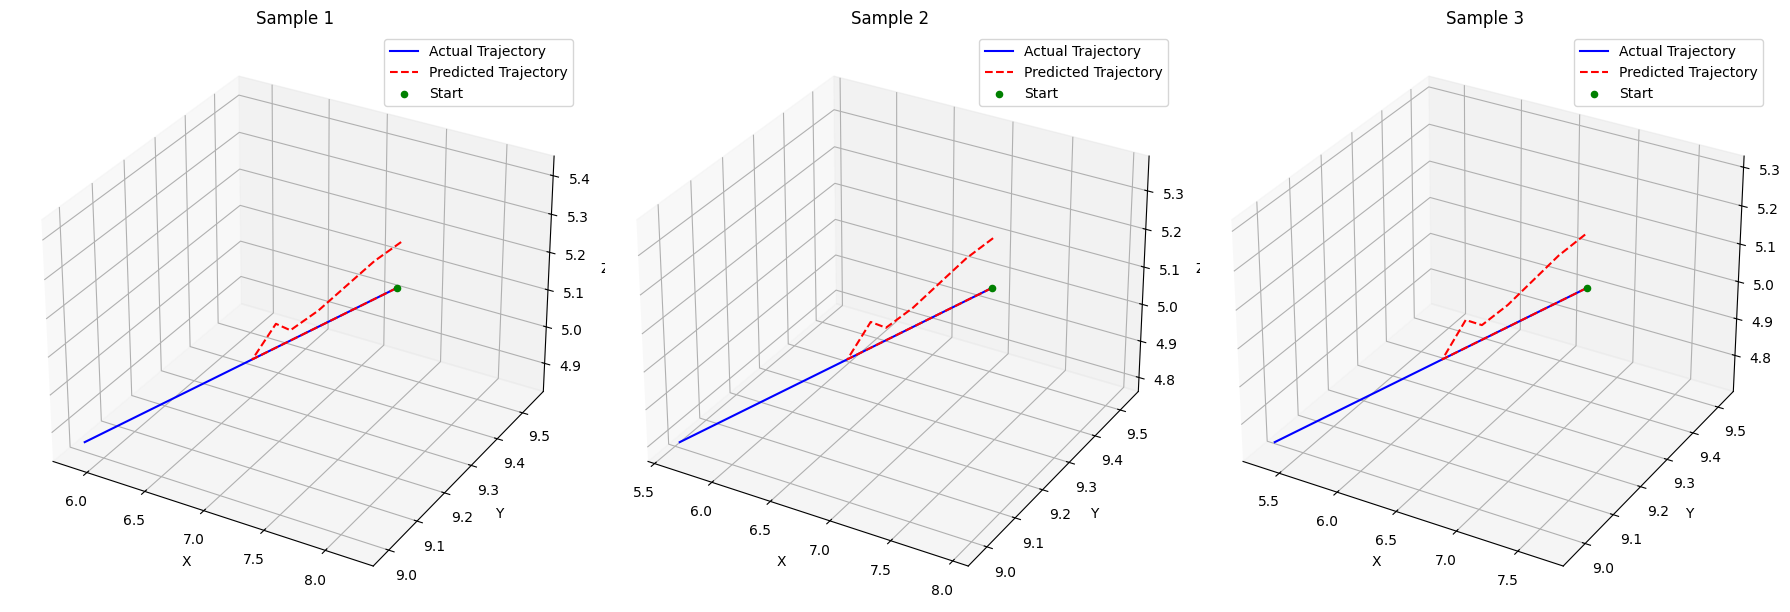

In [ ]:
num_samples = 1000
num_time_steps = 20
pred_seq_len = 5
input_seq_len = 5
bias_value = 0.0

model = GCA_MLP(hidden_dim=16, num_layers=2, N=(pred_seq_len))
model = model.to(model.device)

# Loss function and optimizer
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3, weight_decay = 0)

# Generate data
positions = generate_trajectory_data(bias_value, num_samples, num_time_steps)

# Split data into training and testing sets
train_ratio = 0.8
num_train = int(num_samples * train_ratio)
train_positions = positions[:num_train]
test_positions = positions[num_train:]

# Create DataLoaders
batch_size = 32
train_dataset = TrajectoryDataset(train_positions, input_seq_len=input_seq_len, pred_seq_len=pred_seq_len)
print("Dataset length:", len(train_dataset))
test_dataset = TrajectoryDataset(test_positions, input_seq_len=5, pred_seq_len=pred_seq_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training loop
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (input_position, target_position) in enumerate(train_loader):
        input_position = input_position.to(model.device)  # Shape: [batch_size, input_seq_len, 3]
        target_position = target_position.to(model.device)  # Shape: [batch_size, pred_seq_len, 3]
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Flatten input_position to match model input
        input_flat = input_position.view(batch_size, -1)

        # Forward pass
        output = model(input_flat)  # Output shape: [batch_size, pred_seq_len, 3]

        # Compute loss over the sequence
        loss = criterion(output, target_position)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item() * input_position.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

# Testing loop
model.eval()
all_inputs = []
all_targets = []
all_predictions = []
with torch.no_grad():
    total_loss = 0
    for input_position, target_position in test_loader:
        input_position = input_position.to(model.device)
        target_position = target_position.to(model.device)

        # Forward pass
        output = model(input_position)

        # Compute loss
        loss = criterion(output, target_position)
        total_loss += loss.item() * input_position.size(0)

        # Collect data for plotting
        all_inputs.append(input_position.cpu())
        all_targets.append(target_position.cpu())
        all_predictions.append(output.cpu())

    avg_loss = total_loss / len(test_loader.dataset)
    print(f"Test Loss: {avg_loss:.6f}")

# Concatenate all data
all_inputs = torch.cat(all_inputs, dim=0)
all_targets = torch.cat(all_targets, dim=0)
all_predictions = torch.cat(all_predictions, dim=0)

# Plotting predicted vs. actual trajectories
# Plotting predicted vs. actual trajectories
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

num_plot_samples = 3  # Number of samples to plot
fig = plt.figure(figsize=(18, 6))

for i in range(num_plot_samples):
    # Get input and target positions for sample i
    input_position = all_inputs[i].numpy()  # Shape: [input_seq_len, 3]
    target_position = all_targets[i].numpy()  # Shape: [pred_seq_len, 3]
    prediction = all_predictions[i].numpy()  # Shape: [pred_seq_len, 3]

    # Concatenate input and target positions
    full_target_pos = np.concatenate([input_position, target_position], axis=0)
    full_pred_pos = np.concatenate([input_position, prediction], axis=0)

    ax = fig.add_subplot(1, num_plot_samples, i + 1, projection='3d')
    ax.plot(full_target_pos[:, 0], full_target_pos[:, 1], full_target_pos[:, 2], 'b-', label='Actual Trajectory')
    ax.plot(full_pred_pos[:, 0], full_pred_pos[:, 1], full_pred_pos[:, 2], 'r--', label='Predicted Trajectory')
    ax.scatter(input_position[0, 0], input_position[0, 1], input_position[0, 2], c='g', marker='o', label='Start')
    ax.legend()
    ax.set_title(f"Sample {i+1}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
plt.tight_layout()
plt.show()

## **Testing: MNIST**

In [ ]:
import torch
import torch.nn as nn
import math
from clifford import Cl
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the geometric algebra parameters for Cl(2, 0)
layout, blades = Cl(2, 0)
num_blades = len(layout.blades_list)  # Should be 4 for Cl(2, 0)
# Create blade mappings
blade_tuple_to_idx = {key: idx for idx, key in enumerate(layout.blades.keys())}
idx_to_blade_tuple = {idx: key for key, idx in blade_tuple_to_idx.items()}

def get_clifford_left_kernel(M, w):
    return torch.einsum('oi,ijk->ojk', w, M)  # [out_features, num_blades, num_blades]

def get_clifford_right_kernel(M, w):
    return torch.einsum('oi,kji->ojk', w, M)  # [out_features, num_blades, num_blades]

class MultiVectorEmbedding(nn.Module):
    def __init__(self, layout, input_dim):
        super().__init__()
        self.layout = layout
        self.input_dim = input_dim
        self.num_blades = len(layout.blades_list)
        self.linear = nn.Linear(input_dim, self.num_blades)

    def encode(self, x):
        # x shape: [batch_size, input_dim]
        components = self.linear(x)  # [batch_size, num_blades]
        return components

class CliffordAlgebra:
    def __init__(self, layout):
        self.layout = layout
        self.metric = layout.sig
        self.gmt = layout.gmt
        # Convert the sparse GMT to a dense PyTorch tensor
        self.cayley = torch.tensor(layout.gmt.todense(), dtype=torch.float32)
        # Create the mapping from blade tuples to indices
        blade_tuples = self.layout.bladeTupList
        self.blade_tuple_to_idx = {blade_tuples[i]: i for i in range(len(blade_tuples))}
        self.num_blades = len(blade_tuples)

    def reverse(self, mv):
        if not torch.is_tensor(mv):
            raise TypeError("Input to reverse must be a torch.Tensor")

        # Get the grades of the blades
        grades = torch.tensor([self.layout.gradeList[blade_idx] for blade_idx in range(self.num_blades)],
                              dtype=mv.dtype, device=mv.device)
        # Compute reverse signs: sign = (-1)^{r(r-1)/2}
        reverse_signs = (-1) ** ((grades * (grades - 1)) // 2)

        # Apply reverse signs
        return mv * reverse_signs

    def embed(self, tensor, blades):
        batch_shape = tensor.shape[:-1]
        mv_tensor = torch.zeros(*batch_shape, self.num_blades, device=tensor.device)
        for idx, blade_idx in enumerate(blades):
            mv_tensor[..., int(blade_idx)] = tensor[..., idx]
        return mv_tensor

    def norm(self, mv):
        return torch.sqrt(torch.sum(mv ** 2, dim=-1))

class PGAConjugateLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        algebra,
        input_blades,
        action_blades=None,
    ):
        super().__init__()
        self.input_blades = input_blades
        self.in_features = in_features
        self.out_features = out_features
        self.algebra = algebra

        if action_blades is None:
            # Use vector blades (grade-1 blades)
            action_blades = [
                self.algebra.blade_tuple_to_idx[(1,)],
                self.algebra.blade_tuple_to_idx[(2,)],
            ]
            self.action_blades = [int(idx) for idx in action_blades]
        else:
            self.action_blades = [int(idx) for idx in action_blades]

        self.n_action_blades = len(self.action_blades)

        # Parameters
        self._action = nn.Parameter(torch.empty(out_features, self.n_action_blades))  # [out_features, n_action_blades]
        self.weight = nn.Parameter(torch.empty(out_features, in_features))  # [out_features, in_features]

        self.inverse = self.algebra.reverse

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.uniform_(self._action, -1, 1)

        # Normalize the action
        action_mv = self.algebra.embed(self._action.data, self.action_blades)  # [out_features, num_blades]
        norm = self.algebra.norm(action_mv)  # [out_features]

        epsilon = 1e-12
        norm = norm.unsqueeze(-1)  # [out_features,1]
        self._action.data = self._action.data / (norm + epsilon)  # [out_features, n_action_blades]

        # Initialize weights
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

    @property
    def action(self):
        return self.algebra.embed(self._action, self.action_blades)  # [out_features, num_blades]

    def forward(self, input):
        # input: [batch_size, in_channels, num_blades]
        batch_size, in_channels, num_blades = input.shape
        M = self.algebra.cayley.to(input.device)  # [num_blades, num_blades, num_blades]
        k = self.action.to(input.device)  # [out_features, num_blades]
        k_ = self.inverse(k)  # [out_features, num_blades]

        k_l = get_clifford_left_kernel(M, k)
        k_r = get_clifford_right_kernel(M, k_)

        k_l = k_l.unsqueeze(0).repeat(batch_size * in_channels, 1, 1, 1)
        k_r = k_r.unsqueeze(0).repeat(batch_size * in_channels, 1, 1, 1)

        x = input.view(batch_size * in_channels, 1, num_blades)

        x = torch.einsum('bij,bijk->bik', x, k_l)
        x = torch.einsum('bij,bijk->bik', x, k_r)

        # x now has shape [batch_size * in_channels, out_channels, num_blades]
        x = x.view(batch_size, in_channels, self.out_features, num_blades)

        # Apply weights
        weight = self.weight.t().unsqueeze(0).unsqueeze(-1)  # [1, in_channels, out_features, 1]
        x = x * weight  # Element-wise multiplication

        # Sum over in_channels
        x = x.sum(dim=1)  # [batch_size, out_features, num_blades]

        return x

class MultiVectorAct(nn.Module):
    def __init__(self, channels, layout, input_blades, kernel_blades=None, agg="linear"):
        super().__init__()
        self.layout = layout
        self.input_blades = tuple(input_blades)
        if kernel_blades is not None:
            self.kernel_blades = tuple(kernel_blades)
        else:
            self.kernel_blades = self.input_blades

        self.agg = agg

    def forward(self, input):
        if self.agg == "linear":
            activation = torch.sigmoid(input)
            x = input * activation
        elif self.agg == "sum":
            activation = torch.sigmoid(input[..., self.kernel_blades].sum(dim=-1, keepdim=True))
            x = input * activation
        elif self.agg == "mean":
            activation = torch.sigmoid(input[..., self.kernel_blades].mean(dim=-1, keepdim=True))
            x = input * activation
        else:
            raise ValueError(f"Aggregation {self.agg} not implemented.")
        return x

class MSiLU(MultiVectorAct):
    def __init__(self, channels, layout):
        num_blades = len(layout.blades_list)
        super().__init__(
            channels=channels,
            layout=layout,
            input_blades=tuple(range(num_blades)),
            agg='linear'
        )

class CliffordNormalization(nn.Module):
    def __init__(self, num_features, num_blades):
        super().__init__()
        self.bn = nn.BatchNorm1d(num_features * num_blades)

    def forward(self, x):
        batch_size, channels, num_blades = x.shape
        x_flat = x.view(batch_size, channels * num_blades)
        x_norm = self.bn(x_flat)
        x_norm = x_norm.view(batch_size, channels, num_blades)
        return x_norm

class GCALayer(nn.Module):
    def __init__(self, in_channels, out_channels, algebra):
        super().__init__()
        self.algebra = algebra
        self.num_blades = self.algebra.num_blades
        self.conj_linear = PGAConjugateLinear(
            in_features=in_channels,
            out_features=out_channels,
            algebra=algebra,
            input_blades=tuple(range(self.num_blades))
        )
        self.normalization = CliffordNormalization(out_channels, self.num_blades)
        self.activation = MSiLU(channels=out_channels, layout=layout)

    def forward(self, x):
        x = self.conj_linear(x)
        x = self.normalization(x)
        x = self.activation(x)
        return x

class GCA_MLP(nn.Module):
    def __init__(self, hidden_dim=16, num_layers=3, N=10, input_dim=784):
        super().__init__()
        self.N = N
        self.algebra = CliffordAlgebra(layout)
        self.num_blades = self.algebra.num_blades
        layers = []
        in_channels = 1  # Since the input will be of shape [batch_size, 1, num_blades]
        for i in range(num_layers):
            if i == num_layers - 1:
                out_channels = 1  # Keep output as [batch_size, 1, num_blades]
            else:
                out_channels = hidden_dim
            layers.append(GCALayer(in_channels, out_channels, self.algebra))
            in_channels = out_channels
        self.layers = nn.ModuleList(layers)
        self.embedding = MultiVectorEmbedding(layout, input_dim)
        self.output_linear = nn.Linear(self.num_blades, N)  # Map multivector components to logits
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def forward(self, x):
        # x shape: [batch_size, input_dim]
        x = x.view(x.size(0), -1)  # Flatten image
        x = self.embedding.encode(x)  # [batch_size, num_blades]
        x = x.to(self.device)
        x = x.unsqueeze(1)  # Add channels dimension: [batch_size, 1, num_blades]
        for layer in self.layers:
            x = layer(x)
        # Output shape: [batch_size, out_channels, num_blades]
        # For the last layer, out_channels is 1
        x = x.squeeze(1)
        logits = self.output_linear(x)
        return logits

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 138MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 13.9MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 24.7MB/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.50MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Train Epoch: 1 [0/60000 (0%)]	Loss: 2.371350
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.992653
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.765276
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.684200
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.689990
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.760217
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.461246
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.367032
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.648837
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.408023

Test set: Average loss: 0.5052, Accuracy: 8554/10000 (86%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.533391
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.533685
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.438426
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.387040
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.289829
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.432314
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.343407
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.737815
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.407271
T

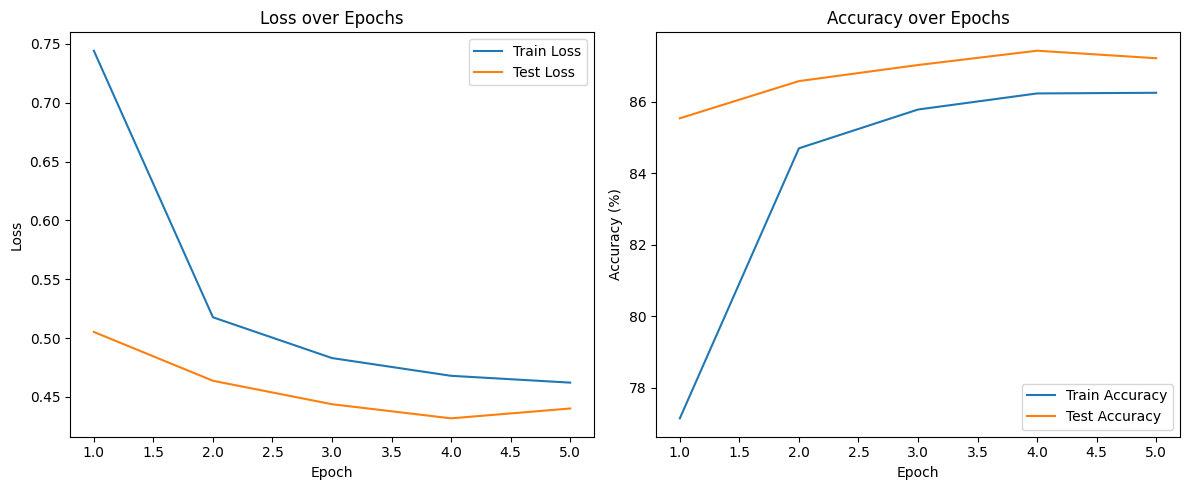

2min 38s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
# Data loading and training code
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += data.size(0)
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    avg_loss = total_loss / total
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def test(model, device, test_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss(reduction='sum')
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)     # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.size(0)
    avg_loss = test_loss / total
    accuracy = 100. * correct / total
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')
    return avg_loss, accuracy

def main():
    # Training settings
    batch_size = 64
    test_batch_size = 1000
    epochs = 5
    lr = 0.01
    hidden_dim = 16
    num_layers = 3

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # MNIST Dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True,
                                   transform=transform)
    test_dataset = datasets.MNIST('./data', train=False,
                                  transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=1, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size,
                             shuffle=False, num_workers=1, pin_memory=True)

    model = GCA_MLP(hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
        test_loss, test_acc = test(model, device, test_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    %timeit -n1 -r1 main()

## **Testing: Iris**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from clifford import Cl
from torch.utils.data import DataLoader, TensorDataset
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

layout, blades = Cl(2, 0)
num_blades = len(layout.blades_list)  # Should be 4 for Cl(2, 0)

blade_tuple_to_idx = {key: idx for idx, key in enumerate(layout.blades.keys())}
idx_to_blade_tuple = {idx: key for key, idx in blade_tuple_to_idx.items()}

def get_clifford_left_kernel(M, w):
    return torch.einsum('oi,ijk->ojk', w, M)  # [out_features, num_blades, num_blades]

def get_clifford_right_kernel(M, w):
    return torch.einsum('oi,kji->ojk', w, M)  # [out_features, num_blades, num_blades]

class MultiVectorEmbedding(nn.Module):
    def __init__(self, layout, input_dim):
        super().__init__()
        self.layout = layout
        self.input_dim = input_dim
        self.num_blades = len(layout.blades_list)
        self.linear = nn.Linear(input_dim, self.num_blades)

    def encode(self, x):
        # x shape: [batch_size, input_dim]
        components = self.linear(x)  # [batch_size, num_blades]
        return components

class CliffordAlgebra:
    def __init__(self, layout):
        self.layout = layout
        self.metric = layout.sig
        self.gmt = layout.gmt
        # Convert the sparse GMT to a dense PyTorch tensor
        self.cayley = torch.tensor(layout.gmt.todense(), dtype=torch.float32)
        # Create the mapping from blade tuples to indices
        blade_tuples = self.layout.bladeTupList
        self.blade_tuple_to_idx = {blade_tuples[i]: i for i in range(len(blade_tuples))}
        self.num_blades = len(blade_tuples)

    def reverse(self, mv):
        if not torch.is_tensor(mv):
            raise TypeError("Input to reverse must be a torch.Tensor")

        # Get the grades of the blades
        grades = torch.tensor([self.layout.gradeList[blade_idx] for blade_idx in range(self.num_blades)],
                              dtype=mv.dtype, device=mv.device)
        # Compute reverse signs: sign = (-1)^{r(r-1)/2}
        reverse_signs = (-1) ** ((grades * (grades - 1)) // 2)

        # Apply reverse signs
        return mv * reverse_signs

    def embed(self, tensor, blades):
        batch_shape = tensor.shape[:-1]
        mv_tensor = torch.zeros(*batch_shape, self.num_blades, device=tensor.device)
        for idx, blade_idx in enumerate(blades):
            mv_tensor[..., int(blade_idx)] = tensor[..., idx]
        return mv_tensor

    def norm(self, mv):
        return torch.sqrt(torch.sum(mv ** 2, dim=-1))

class PGAConjugateLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        algebra,
        input_blades,
        action_blades=None,
    ):
        super().__init__()
        self.input_blades = input_blades
        self.in_features = in_features
        self.out_features = out_features
        self.algebra = algebra

        if action_blades is None:
            # Use vector blades (grade-1 blades)
            action_blades = [
                self.algebra.blade_tuple_to_idx[(1,)],
                self.algebra.blade_tuple_to_idx[(2,)],
            ]
            self.action_blades = [int(idx) for idx in action_blades]
        else:
            self.action_blades = [int(idx) for idx in action_blades]

        self.n_action_blades = len(self.action_blades)

        # Parameters
        self._action = nn.Parameter(torch.empty(out_features, self.n_action_blades))  # [out_features, n_action_blades]
        self.weight = nn.Parameter(torch.empty(out_features, in_features))  # [out_features, in_features]

        self.inverse = self.algebra.reverse

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.uniform_(self._action, -1, 1)

        # Normalize the action
        action_mv = self.algebra.embed(self._action.data, self.action_blades)  # [out_features, num_blades]
        norm = self.algebra.norm(action_mv)  # [out_features]

        epsilon = 1e-12
        norm = norm.unsqueeze(-1)  # [out_features,1]
        self._action.data = self._action.data / (norm + epsilon)  # [out_features, n_action_blades]

        # Initialize weights
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

    @property
    def action(self):
        return self.algebra.embed(self._action, self.action_blades)  # [out_features, num_blades]

    def forward(self, input):
        # input: [batch_size, in_channels, num_blades]
        batch_size, in_channels, num_blades = input.shape
        M = self.algebra.cayley.to(input.device)  # [num_blades, num_blades, num_blades]
        k = self.action.to(input.device)  # [out_features, num_blades]
        k_ = self.inverse(k)  # [out_features, num_blades]

        # Compute k_l and k_r
        k_l = get_clifford_left_kernel(M, k)  # [out_features, num_blades, num_blades]
        k_r = get_clifford_right_kernel(M, k_)  # [out_features, num_blades, num_blades]

        # Reshape k_l and k_r for batch computation
        k_l = k_l.unsqueeze(0).repeat(batch_size * in_channels, 1, 1, 1)
        k_r = k_r.unsqueeze(0).repeat(batch_size * in_channels, 1, 1, 1)

        # Reshape x for batch computation
        x = input.view(batch_size * in_channels, 1, num_blades)  # [batch_size*in_channels, 1, num_blades]

        # Apply geometric transformations
        x = torch.einsum('bij,bijk->bik', x, k_l)  # Left multiplication
        x = torch.einsum('bij,bijk->bik', x, k_r)  # Right multiplication

        # x now has shape [batch_size * in_channels, out_channels, num_blades]
        x = x.view(batch_size, in_channels, self.out_features, num_blades)

        # Apply weights
        weight = self.weight.t().unsqueeze(0).unsqueeze(-1)  # [1, in_channels, out_features, 1]
        x = x * weight  # Element-wise multiplication

        # Sum over in_channels
        x = x.sum(dim=1)  # [batch_size, out_features, num_blades]

        return x

class MultiVectorAct(nn.Module):
    def __init__(self, channels, layout, input_blades, kernel_blades=None, agg="linear"):
        super().__init__()
        self.layout = layout
        self.input_blades = tuple(input_blades)
        if kernel_blades is not None:
            self.kernel_blades = tuple(kernel_blades)
        else:
            self.kernel_blades = self.input_blades

        self.agg = agg

    def forward(self, input):
        if self.agg == "linear":
            activation = torch.sigmoid(input)
            x = input * activation
        elif self.agg == "sum":
            activation = torch.sigmoid(input[..., self.kernel_blades].sum(dim=-1, keepdim=True))
            x = input * activation
        elif self.agg == "mean":
            activation = torch.sigmoid(input[..., self.kernel_blades].mean(dim=-1, keepdim=True))
            x = input * activation
        else:
            raise ValueError(f"Aggregation {self.agg} not implemented.")
        return x

class MSiLU(MultiVectorAct):
    def __init__(self, channels, layout):
        num_blades = len(layout.blades_list)
        super().__init__(
            channels=channels,
            layout=layout,
            input_blades=tuple(range(num_blades)),
            agg='linear'
        )

class CliffordNormalization(nn.Module):
    def __init__(self, num_features, num_blades):
        super().__init__()
        self.bn = nn.BatchNorm1d(num_features * num_blades)

    def forward(self, x):
        batch_size, channels, num_blades = x.shape
        x_flat = x.view(batch_size, channels * num_blades)
        x_norm = self.bn(x_flat)
        x_norm = x_norm.view(batch_size, channels, num_blades)
        return x_norm

class GCALayer(nn.Module):
    def __init__(self, in_channels, out_channels, algebra):
        super().__init__()
        self.algebra = algebra
        self.num_blades = self.algebra.num_blades
        self.conj_linear = PGAConjugateLinear(
            in_features=in_channels,
            out_features=out_channels,
            algebra=algebra,
            input_blades=tuple(range(self.num_blades))
        )
        self.normalization = CliffordNormalization(out_channels, self.num_blades)
        self.activation = MSiLU(channels=out_channels, layout=layout)

    def forward(self, x):
        x = self.conj_linear(x)
        x = self.normalization(x)
        x = self.activation(x)
        return x

class GCA_MLP(nn.Module):
    def __init__(self, hidden_dim=16, num_layers=3, N=3, input_dim=4):
        super().__init__()
        self.N = N
        self.algebra = CliffordAlgebra(layout)
        self.num_blades = self.algebra.num_blades
        layers = []
        in_channels = 1  # Since the input will be of shape [batch_size, 1, num_blades]
        for i in range(num_layers):
            if i == num_layers - 1:
                out_channels = 1  # Keep output as [batch_size, 1, num_blades]
            else:
                out_channels = hidden_dim
            layers.append(GCALayer(in_channels, out_channels, self.algebra))
            in_channels = out_channels
        self.layers = nn.ModuleList(layers)
        self.embedding = MultiVectorEmbedding(layout, input_dim)
        self.output_linear = nn.Linear(self.num_blades, N)  # Map multivector components to logits
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def forward(self, x):
        # x shape: [batch_size, input_dim]
        x = x.view(x.size(0), -1)  # Ensure x is of shape [batch_size, input_dim]
        x = self.embedding.encode(x)  # [batch_size, num_blades]
        x = x.to(self.device)
        x = x.unsqueeze(1)  # Add channels dimension: [batch_size, 1, num_blades]
        for layer in self.layers:
            x = layer(x)
        # Output shape: [batch_size, out_channels, num_blades]
        # For the last layer, out_channels is 1
        x = x.squeeze(1)  # [batch_size, num_blades]
        logits = self.output_linear(x)  # [batch_size, N]
        return logits

In [ ]:
# Data loading and training code
def train(model, device, train_loader, optimizer, epoch, train_losses):
    model.train()
    criterion = nn.MSELoss()
    total_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device).float(), target.to(device)
        optimizer.zero_grad()
        output = model(data)  # [batch_size, N]
        # Convert targets to one-hot encoding
        target_one_hot = F.one_hot(target, num_classes=3).float()
        loss = criterion(output, target_one_hot)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        total_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += data.size(0)
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} \tLoss: {loss.item():.6f}')
    avg_loss = total_loss / total
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def test(model, device, test_loader, test_losses):
    model.eval()
    criterion = nn.MSELoss(reduction='sum')
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device).float(), target.to(device)
            output = model(data)  # [batch_size, N]
            # Convert targets to one-hot encoding
            target_one_hot = F.one_hot(target, num_classes=3).float()
            batch_loss = criterion(output, target_one_hot).item()
            test_loss += batch_loss  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)     # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_losses.append(batch_loss / len(data))  # Average loss for the batch
            total += data.size(0)
    test_loss /= len(test_loader.dataset)
    avg_loss = test_loss / total
    accuracy = 100. * correct / total
    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')
    return avg_loss, accuracy

def main():
    batch_size = 16
    test_batch_size = 16
    epochs = 15
    lr = 0.01
    hidden_dim = 16
    num_layers = 3

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Load Iris Dataset
    iris = datasets.load_iris()
    X = iris.data  # Features: [150, 4]
    y = iris.target  # Labels: [150]

    # Split into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=1)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size,
                             shuffle=False, num_workers=1)

    model = GCA_MLP(hidden_dim=hidden_dim, num_layers=num_layers, N=3, input_dim=4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Lists to store losses
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
        test_loss, test_acc = test(model, device, test_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

    # Plotting
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

TypeError: train() missing 1 required positional argument: 'train_losses'

## **Testing World Geometries Dataset**


This code processes geographical data represented as polygons for countries. It performs the following steps:

**Feature Extraction:** If a polygon has $n$ coordinates, it is padded to a fixed length `max_len` using zero-padding. This ensures uniformity across all data points, allowing for consistent processing in the model.

$$
Feature vector=[x_1,y_1,x_2,y_2,…,x_n,y_n,0,0,…]
$$


**Padding:** The features are padded to ensure a uniform length.

**Tensor Conversion:** Both the features and labels are converted into PyTorch tensors.

Next, a neural network model is applied for classification. Key components include:

**Custom Convolution Function:** The `conv_fn` function processes the extracted features. This function applies a 2D convolution to the input tensor, which reshapes the data to a 2D format with a single channel and a height of 1. The convolution is computed using a kernel, stride, padding, and dilation:
$$
y = conv2d(x,W,b)
$$

**Training Loop:** The model is trained using the Adam optimizer and L1 loss to predict the labels (country names).



The training runs for 100 epochs, utilizing backpropagation to update the model's weights based on the computed gradients, aiming to minimize the loss.
$$
L = \frac{1}{n}\sum_{i=1}^{N}|\hat{y_i} - y_i|
$$

During the training loop, the gradients of the loss with respect to the model parameters are computed using backpropagation. The optimizer we used is Adam

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Prepare geometric product multiplication table
def compute_multiplication_table(n):
    num_blades = 2 ** n
    mult_table = torch.zeros(num_blades, num_blades, num_blades)
    blade_tuples = generate_blade_tuples(n)
    blade_tuple_to_idx = {blade: idx for idx, blade in enumerate(blade_tuples)}

    for i, blade_i in enumerate(blade_tuples):
        for j, blade_j in enumerate(blade_tuples):
            sign = 1
            blade_k = list(blade_i)
            for idx in blade_j:
                if idx in blade_k:
                    blade_k.remove(idx)
                    sign *= -1
                else:
                    swaps = sum(1 for x in blade_k if x > idx)
                    sign *= (-1) ** swaps
                    blade_k.append(idx)
                    blade_k.sort()
            blade_k = tuple(blade_k)
            if blade_k in blade_tuple_to_idx:
                k = blade_tuple_to_idx[blade_k]
                mult_table[i, j, k] = sign
    return mult_table, blade_tuple_to_idx

n = 2  # 2D geometry (x, y)
mult_table, blade_tuple_to_idx = compute_multiplication_table(n)
num_blades = 2 ** n

print (X.shape)
print (y.shape)

# Training Loop
model = CliffordGeoClassifier(X_train.shape[1], len(label_encoder.classes_), num_blades, mult_table)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

for epoch in range(100):
    model.train()
    for data, target in train_dataset:
        optimizer.zero_grad()
        outputs = conv_fn(X_train, 1)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")

torch.Size([150, 406])
torch.Size([150])


ValueError: Expected input batch_size (120) to match target batch_size (150).

The loss values are consistently high, indicating that our GCA-MLP doesn't work well in this context.

##**Traditional MLP and CNN**

For comparision and results

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
mlp_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

NameError: name 'X_train' is not defined

A CNN used with image data from the world geometry dataset, we observed that CNNs perform significantly better with 2D data



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving country_images.zip to country_images.zip


In [ ]:
#extracting image files
import zipfile
import os
zip_path = '/content/country_images.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
os.listdir('/content/')

['.config',
 '.ipynb_checkpoints',
 'class G',
 'Q',
 'F',
 'J',
 'U',
 'training_results.csv',
 'H',
 'M',
 'V',
 'S',
 'A',
 'E',
 'R',
 'W',
 'N',
 'Y',
 'G',
 'B',
 'Z',
 'training_results_with_geometric_transformations.csv',
 'K',
 'T',
 'I',
 'C',
 'D',
 'O',
 'country_images.zip',
 'P',
 'sample_data',
 'L']

In [ ]:
# Define the paths and parameters
data_dir = "/content/country images"
image_size = (128, 128)
batch_size = 32

# Create an ImageDataGenerator for rescaling and data augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2
)

# Load the training data (80% of the images)
train_data = datagen.flow_from_directory(
    directory=data_dir,
    target_size=image_size,
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'  # For multi-class classification
)

val_data = datagen.flow_from_directory(
    directory=data_dir,
    target_size=image_size,
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)


Found 150 images belonging to 26 classes.
Found 23 images belonging to 26 classes.


In [ ]:
# Define the CNN model
model = Sequential([
    # Convolutional Layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    # Fully connected layer
    Dense(128, activation='relu'),
    Dense(train_data.num_classes, activation='softmax')  # Output layer, num_classes for multi-class
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use binary crossentropy for binary classification
    metrics=['mean_absolute_error']
)

# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,307,994 (12.62 MB)

 Trainable params: 3,307,994 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

AttributeError: 'GeoClassifier' object has no attribute 'fit'

In [ ]:
def train_with_cnn():
    # Data preparation
    num_samples = 100
    num_timesteps = 5
    batch_size = 16
    num_epochs = 300
    hidden_dim = 32
    output_dim = 3  # Predicting the next position (3D vector)

    # Generate synthetic data
    positions = np.random.rand(num_samples, num_timesteps, 3)
    velocities = np.random.rand(num_samples, 3) * 0.1

    # Generate positions over timesteps (linear motion)
    for t in range(1, num_timesteps):
        positions[:, t, :] = positions[:, t - 1, :] + velocities

    # Prepare inputs and targets for CNN
    input_positions = positions[:, :num_timesteps - 1, :]  # Shape: (num_samples, num_timesteps-1, 3)
    target_positions = positions[:, 1:, :]  # Shape: (num_samples, num_timesteps-1, 3)

    # Reshape for CNN: (batch_size, input_channels, num_timesteps)
    input_positions = input_positions.transpose(0, 2, 1)  # Shape: (num_samples, 3, num_timesteps-1)
    input_positions = torch.tensor(input_positions, dtype=torch.float32)
    target_positions = torch.tensor(target_positions, dtype=torch.float32)

    # Initialize CNN, loss function, and optimizer
    model = TetrisCNN(input_channels=3, hidden_dim=hidden_dim, output_dim=output_dim)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for i in range(0, num_samples, batch_size):
            optimizer.zero_grad()

            # Prepare batch data
            batch_input = input_positions[i:i+batch_size]  # Shape: (batch_size, 3, num_timesteps-1)
            batch_target = target_positions[i:i+batch_size]  # Shape: (batch_size, num_timesteps-1, 3)

            # Predict the next timestep positions
            predicted_positions = model(batch_input)  # Shape: (batch_size, 3)

            # Compute loss
            loss = criterion(predicted_positions, batch_target[:, 0, :])  # Compare only first timestep
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / (num_samples / batch_size)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")


# **Implementation of Our GCA-MLP in Robot Dynamics**

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from clifford import Cl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#train
def load_split_data(split_dir, split_name):
    split_path = "/content/sample_data/nao_dataset/train/LTrain_x.csv"
    data = pd.read_csv(split_path)

    positions = data[['Px', 'Py', 'Pz']].values
    rotations = data[['Rx', 'Ry', 'Rz']].values

    # Define custom labels based on position ('Px')
    data['label'] = (data['Px'] > 0).astype(int)
    labels = data['label'].values

    # Convert to tensors
    positions_tensor = torch.tensor(positions, dtype=torch.float32)
    rotations_tensor = torch.tensor(rotations, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return positions_tensor, rotations_tensor, labels_tensor

#test
def load_test_data(test_file):
    test_path = "/content/sample_data/nao_dataset/test/LTest_x.csv"
    data = pd.read_csv(test_path)

    positions = data[['Px', 'Py', 'Pz']].values
    rotations = data[['Rx', 'Ry', 'Rz']].values
    labels = (data['Px'] > 0).astype(int).values

    positions_tensor = torch.tensor(positions, dtype=torch.float32)
    rotations_tensor = torch.tensor(rotations, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return positions_tensor, rotations_tensor, labels_tensor

#validation
def load_val_data(val_file):
    val_path = "/content/sample_data/nao_dataset/val/LVal_x.csv"
    data = pd.read_csv(val_path)

    positions = data[['Px', 'Py', 'Pz']].values
    rotations = data[['Rx', 'Ry', 'Rz']].values

    labels = (data['Px'] > 0).astype(int).values

    positions_tensor = torch.tensor(positions, dtype=torch.float32)
    rotations_tensor = torch.tensor(rotations, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return positions_tensor, rotations_tensor, labels_tensor

dataset_dir = "/content/sample_data/nao_dataset"
train_positions, train_rotations, train_labels = load_split_data(dataset_dir, 'train')
val_positions, val_rotations, val_labels = load_split_data(dataset_dir, 'val')
test_positions, test_rotations, test_labels = load_split_data(dataset_dir, 'test')

train_features = torch.cat((train_positions, train_rotations), dim=1)
val_features = torch.cat((val_positions, val_rotations), dim=1)
test_features = torch.cat((test_positions, test_rotations), dim=1)

# Create PyTorch datasets and dataloaders
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_features, train_labels)
val_dataset = TensorDataset(val_features, val_labels)
test_dataset = TensorDataset(test_features, test_labels)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# Step 6: Define GeoLayer using Clifford Algebra
layout, blades = Cl(3)
e1, e2, e3 = blades['e1'], blades['e2'], blades['e3']

class GeoLayer(nn.Module):
    def __init__(self):
        super(GeoLayer, self).__init__()

    def forward(self, positions, rotations):
        # Convert positions and rotations to multivectors using Clifford algebra
        scalar_features = []
        for i in range(positions.size(0)):
            # Convert inputs to multivectors (positions and rotations as geometric vectors)
            p = e1 * positions[i, 0] + e2 * positions[i, 1] + e3 * positions[i, 2]
            r = e1 * rotations[i, 0] + e2 * rotations[i, 1] + e3 * rotations[i, 2]

            # Combine position and rotation information
            geo_vector = p + r

            # Calculate the magnitude (scalar feature) of the geometric vector
            scalar_features.append((geo_vector * ~geo_vector).value[0])  # geo_vector * ~geo_vector gives the norm

        scalar_features = torch.tensor(scalar_features, dtype=torch.float32).unsqueeze(1)  # Make it a 2D tensor
        return scalar_features

# Step 7: GeoClassifier Model
class GeoClassifier(nn.Module):
    def __init__(self, hidden_dim, num_layers):
        super(GeoClassifier, self).__init__()
        self.geo_layer = GeoLayer()
        self.mlp = nn.Sequential(
            nn.Linear(1, 32),  # Single input from GeoLayer
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 2)  # Binary classification (0 or 1)
        )

    def forward(self, positions, rotations):
        # Pass through the GeoLayer
        x = self.geo_layer(positions, rotations)
        # Pass through the MLP
        x = self.mlp(x)
        return x

# Step 8: Initialize model, loss, and optimizer
model = GeoClassifier(hidden_dim=32, num_layers=2)
criterion = nn.CrossEntropyLoss()  # Cross-entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []

# Step 9: Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        positions_rotations, labels = batch
        optimizer.zero_grad()  # Zero the gradients

        positions = positions_rotations[:, :3]  # First 3 columns are positions
        rotations = positions_rotations[:, 3:]  # Last 3 columns are rotations
        outputs = model(positions, rotations)
        loss = criterion(outputs, labels)

        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_loss += loss.item()  # Accumulate loss
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Step 10: Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        positions_rotations, labels = batch  # Unpack the data

        # Split the features into positions and rotations
        positions = positions_rotations[:, :3]  # First 3 columns are positions
        rotations = positions_rotations[:, 3:]  # Last 3 columns are rotations

        # Forward pass
        outputs = model(positions, rotations)

        # Get the predicted class
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


Epoch 1/50, Loss: 505.3612
Epoch 2/50, Loss: 41.8370
Epoch 3/50, Loss: 13.0630
Epoch 4/50, Loss: 6.0140
Epoch 5/50, Loss: 3.3259
Epoch 6/50, Loss: 2.4139
Epoch 7/50, Loss: 2.1530
Epoch 8/50, Loss: 1.3599
Epoch 9/50, Loss: 0.9802
Epoch 10/50, Loss: 1.3454
Epoch 11/50, Loss: 0.9037
Epoch 12/50, Loss: 0.9863
Epoch 13/50, Loss: 0.6898
Epoch 14/50, Loss: 0.7123
Epoch 15/50, Loss: 0.6105
Epoch 16/50, Loss: 0.5180
Epoch 17/50, Loss: 0.5088
Epoch 18/50, Loss: 0.4681
Epoch 19/50, Loss: 0.4844
Epoch 20/50, Loss: 0.5582
Epoch 21/50, Loss: 0.6329
Epoch 22/50, Loss: 0.4951
Epoch 23/50, Loss: 0.4585
Epoch 24/50, Loss: 0.4097
Epoch 25/50, Loss: 0.4152
Epoch 26/50, Loss: 0.4101
Epoch 27/50, Loss: 0.4837
Epoch 28/50, Loss: 0.4241
Epoch 29/50, Loss: 0.4178
Epoch 30/50, Loss: 0.4460
Epoch 31/50, Loss: 0.4324
Epoch 32/50, Loss: 0.3857
Epoch 33/50, Loss: 0.3878
Epoch 34/50, Loss: 0.4094
Epoch 35/50, Loss: 0.3963
Epoch 36/50, Loss: 0.3871
Epoch 37/50, Loss: 0.3828
Epoch 38/50, Loss: 0.3971
Epoch 39/50, Loss